# Predikcia detached kriviek vybranych parametrov
### Model NN s concatenate vrstvou

In [1]:
# LIBRARIES
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from keras.utils import np_utils
from keras.models import load_model
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.metrics import precision_recall_fscore_support
from keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D, SpatialDropout1D, GlobalAveragePooling1D
from keras.layers import Input, Dense, concatenate, Activation, LSTM, Dropout, Flatten
from keras.models import Model
from keras.layers import Concatenate
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping

np.random.seed(1234)
pd.set_option('display.max_rows', None)

In [2]:
def generate_observation_sigma(space_obs_frac=0.5):
    """
    Draws a standard deviation of noise in light curve points from a "true" value provided in synthetic light curve.
    Noise sigma is drawn from bimodal distribution taking into account contributions from space based and earth based
    observations which have different levels of stochastic noise.

    :param space_obs_frac: ratio between earth based and space based observations
    :return: float; standard deviation of the light curve noise
    """
    earth_based_sigma = 4e-3
    space_based_sigma = 2e-4
    sigma = np.random.choice([earth_based_sigma, space_based_sigma], p=[1-space_obs_frac, space_obs_frac])
    return np.random.rayleigh(sigma)

def stochastic_noise_generator(curve):
    """
    Introduces gaussian noise into synthetic observation provided in `curve`.

    :param curve: numpy.array; normalized light curve
    :return: Tuple(numpy.array, float); normalized light curve with added noise, standard deviation of observations
    """
    sigma = generate_observation_sigma()
    return np.random.normal(curve, sigma), np.full(curve.shape, sigma)

## Data loading

In [3]:
data = pd.read_pickle("detached_all_parameters.pkl").reset_index()
data_sample = data.sample(n=200000)

In [4]:
X = []
for row in data_sample["curve"]:
    X.append(row)
X=np.array(X)

In [5]:
y = np.array(data_sample[[
    "inclination",
    "mass_ratio",
    "primary__surface_potential",
    "secondary__surface_potential",
    "t1_t2"]])

In [6]:
# MinMax Scaler
scaler = MinMaxScaler()
y_minmax_scaled = scaler.fit_transform(y)
y_minmax_scaled[0]

array([0.71584635, 0.05050505, 0.17208073, 0.0020424 , 0.7804878 ])

In [7]:
X_train1, X_test, y_train1, y_test = train_test_split(X, y_minmax_scaled, test_size=0.2)

In [8]:
# Adding noise to train data
X_train_n = []
y_train_n = []
for i in range(len(X_train1)):
    for j in range(3):
        curve = stochastic_noise_generator(X_train1[i])
        X_train_n.append(curve[0])
        y_train_n.append(y_train1[i])
X_train_n = np.array(X_train_n)
y_train_n=np.array(y_train_n)

In [9]:
print("Number of records in dataset: ", len(data),
    "\nNumber of records in sample: ", len(X),
    "\nNumber of train data without noise: ", len(X_train1),
    "\nNumber of train data with noise: ", len(X_train_n),
    "\nNumber of test data without noise: ", len(X_test))

Number of records in dataset:  1300000 
Number of records in sample:  200000 
Number of train data without noise:  160000 
Number of train data with noise:  480000 
Number of test data without noise:  40000


In [10]:
y_train_n.shape

(480000, 5)

In [11]:
y_inc = np.array([arr[0] for arr in y_train_n])
y_mass = np.array([arr[1] for arr in y_train_n])
y_prim_potent = np.array([arr[2] for arr in y_train_n])
y_sec_potent = np.array([arr[3] for arr in y_train_n])
y_temp_ratio = np.array([arr[4] for arr in y_train_n])

In [12]:
y_inc.shape

(480000,)

## Model v1

In [28]:
inputs_y = Input(shape=(X_train_n.shape[1], 1))

a = Conv1D(64, kernel_size = 3, padding = "valid")(inputs_y)
a = MaxPooling1D(2)(a)
a = Conv1D(32, kernel_size = 3, padding = "valid")(a)
a = Dense(32, activation='relu')(a)
a = Model(inputs=inputs_y, outputs=a)

b = Conv1D(64, kernel_size = 3, padding = "valid")(inputs_y)
b = MaxPooling1D(2)(b)
b = Conv1D(32, kernel_size = 3, padding = "valid")(b)
b = Dense(32, activation='relu')(b)
b = Model(inputs=inputs_y, outputs=b)

c = Conv1D(64, kernel_size = 3, padding = "valid")(inputs_y)
c = MaxPooling1D(2)(c)
c = Conv1D(32, kernel_size = 3, padding = "valid")(c)
c = Dense(32, activation='relu')(c)
c = Model(inputs=inputs_y, outputs=c)

d = Conv1D(64, kernel_size = 3, padding = "valid")(inputs_y)
d = MaxPooling1D(2)(d)
d = Conv1D(32, kernel_size = 3, padding = "valid")(d)
d = Dense(32, activation='relu')(d)
d = Model(inputs=inputs_y, outputs=d)

e = Conv1D(64, kernel_size = 3, padding = "valid")(inputs_y)
e = MaxPooling1D(2)(e)
e = Conv1D(32, kernel_size = 3, padding = "valid")(e)
e = Dense(32, activation='relu')(e)
e = Model(inputs=inputs_y, outputs=e)

x = concatenate([a.output, b.output, c.output, d.output, e.output])
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

output = Dense(5, activation='linear')(x)

model_multi = Model(inputs=inputs_y, outputs=output)
model_multi.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model_multi.summary())

Model: "functional_47"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, 400, 1)]     0                                            
__________________________________________________________________________________________________
conv1d_25 (Conv1D)              (None, 398, 64)      256         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_27 (Conv1D)              (None, 398, 64)      256         input_4[0][0]                    
__________________________________________________________________________________________________
conv1d_29 (Conv1D)              (None, 398, 64)      256         input_4[0][0]                    
______________________________________________________________________________________

In [29]:
saved_model = "models/norm_det_multi_v1.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

In [30]:
history_multi = model_multi.fit(
    x=X_train_n,
    y=[y_inc, y_mass, y_prim_potent, y_sec_potent, y_temp_ratio],
    validation_split = 0.1,
    epochs = 10,
    verbose = 1,
    callbacks = callbacks_list,
    batch_size = 64)

Epoch 1/10
3375/3375 [==============================] - ETA: 0s - loss: 0.0308 - mae: 0.1305 - mape: 257336.5312
Epoch 00001: val_mae improved from inf to 0.15540, saving model to models\norm_det_multi_v1.hdf5
3375/3375 [==============================] - 703s 208ms/step - loss: 0.0308 - mae: 0.1305 - mape: 257336.5312 - val_loss: 0.0343 - val_mae: 0.1554 - val_mape: 235136.5938
Epoch 2/10
3375/3375 [==============================] - ETA: 0s - loss: 0.0200 - mae: 0.1091 - mape: 230650.7656- ETA: 9s -
Epoch 00002: val_mae improved from 0.15540 to 0.14855, saving model to models\norm_det_multi_v1.hdf5
3375/3375 [==============================] - 702s 208ms/step - loss: 0.0200 - mae: 0.1091 - mape: 230650.7656 - val_loss: 0.0318 - val_mae: 0.1485 - val_mape: 223692.2812
Epoch 3/10
3375/3375 [==============================] - ETA: 0s - loss: 0.0169 - mae: 0.0979 - mape: 218868.6562- ETA: 4s - loss: 0.0169 - mae: 0.09
Epoch 00003: val_mae improved from 0.14855 to 0.11200, saving model to mod

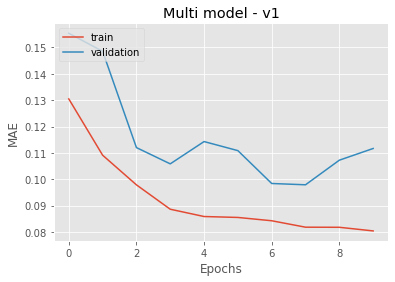

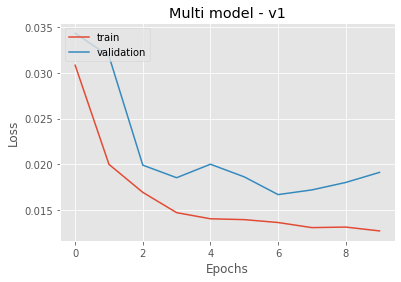

In [32]:
def training_loss(history):
    plt.style.use('ggplot')
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Multi model - v1')
    plt.ylabel('MAE')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.style.use('ggplot')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Multi model - v1')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

training_loss(history_multi)

## Model v2

In [21]:
inputs_y = Input(shape=(X_train_n.shape[1], 1))

a = LSTM(32, return_sequences=True)(inputs_y)
a = MaxPooling1D(2)(a)
a = Dense(32, activation='relu')(a)
a = Model(inputs=inputs_y, outputs=a)

b = LSTM(32, return_sequences=True)(inputs_y)
b = MaxPooling1D(2)(b)
b = Dense(32, activation='relu')(b)
b = Model(inputs=inputs_y, outputs=b)

c = LSTM(32, return_sequences=True)(inputs_y)
c = MaxPooling1D(2)(c)
c = Dense(32, activation='relu')(c)
c = Model(inputs=inputs_y, outputs=c)

d = LSTM(32, return_sequences=True)(inputs_y)
d = MaxPooling1D(2)(d)
d = Dense(32, activation='relu')(d)
d = Model(inputs=inputs_y, outputs=d)

e = LSTM(32, return_sequences=True)(inputs_y)
e = MaxPooling1D(2)(e)
e = Dense(32, activation='relu')(e)
e = Model(inputs=inputs_y, outputs=e)

x = concatenate([a.output, b.output, c.output, d.output, e.output])
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(16, activation='relu')(x)

output = Dense(5, activation='linear')(x)

model_multi_v2 = Model(inputs=inputs_y, outputs=output)
model_multi_v2.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model_multi_v2.summary())

Model: "functional_99"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_9 (InputLayer)            [(None, 400, 1)]     0                                            
__________________________________________________________________________________________________
lstm_37 (LSTM)                  (None, 400, 32)      4352        input_9[0][0]                    
__________________________________________________________________________________________________
lstm_38 (LSTM)                  (None, 400, 32)      4352        input_9[0][0]                    
__________________________________________________________________________________________________
lstm_39 (LSTM)                  (None, 400, 32)      4352        input_9[0][0]                    
______________________________________________________________________________________

In [22]:
saved_model = "models/norm_det_multi_v2.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

In [23]:
history_multi_v2 = model_multi_v2.fit(
    x=X_train_n,
    y=[y_inc, y_mass, y_prim_potent, y_sec_potent, y_temp_ratio],
    validation_split = 0.1,
    epochs = 10,
    verbose = 1,
    callbacks = callbacks_list,
    batch_size = 64)

Epoch 1/10
3375/3375 [==============================] - ETA: 0s - loss: 0.0269 - mae: 0.1233 - mape: 245505.5781
Epoch 00001: val_mae improved from inf to 0.10448, saving model to models\norm_det_multi_v2.hdf5
3375/3375 [==============================] - 1111s 329ms/step - loss: 0.0269 - mae: 0.1233 - mape: 245505.5781 - val_loss: 0.0176 - val_mae: 0.1045 - val_mape: 259749.4844
Epoch 2/10
3375/3375 [==============================] - ETA: 0s - loss: 0.0152 - mae: 0.0918 - mape: 206972.0625
Epoch 00002: val_mae improved from 0.10448 to 0.08705, saving model to models\norm_det_multi_v2.hdf5
3375/3375 [==============================] - 978s 290ms/step - loss: 0.0152 - mae: 0.0918 - mape: 206972.0625 - val_loss: 0.0130 - val_mae: 0.0870 - val_mape: 236313.1250
Epoch 3/10
3375/3375 [==============================] - ETA: 0s - loss: 0.0132 - mae: 0.0846 - mape: 197433.1094
Epoch 00003: val_mae did not improve from 0.08705
3375/3375 [==============================] - 956s 283ms/step - loss: 0

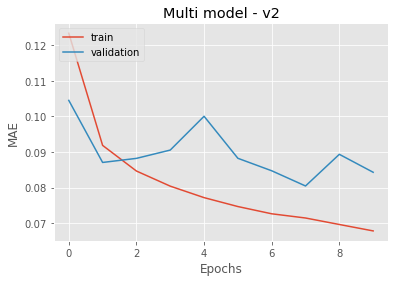

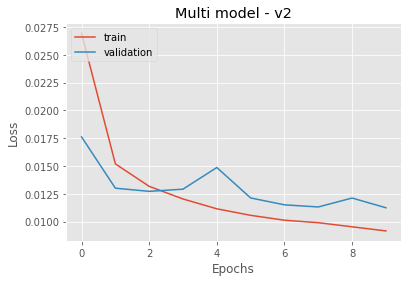

In [26]:
def training_loss(history):
    plt.style.use('ggplot')
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Multi model - v2')
    plt.ylabel('MAE')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.style.use('ggplot')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Multi model - v2')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

training_loss(history_multi_v2)

## Model v3 - trained on sample of 200 000

In [15]:
inputs_y = Input(shape=(X_train_n.shape[1], 1))

a = Conv1D(64, kernel_size = 3, padding = "valid")(inputs_y)
a = LSTM(64, return_sequences=True)(a)
a = Dense(32, activation='relu')(a)
a = Model(inputs=inputs_y, outputs=a)

b = Conv1D(64, kernel_size = 3, padding = "valid")(inputs_y)
b = LSTM(64, return_sequences=True)(b)
b = Dense(32, activation='relu')(b)
b = Model(inputs=inputs_y, outputs=b)

c = Conv1D(64, kernel_size = 3, padding = "valid")(inputs_y)
c = LSTM(64, return_sequences=True)(c)
c = Dense(32, activation='relu')(c)
c = Model(inputs=inputs_y, outputs=c)

d = Conv1D(64, kernel_size = 3, padding = "valid")(inputs_y)
d = LSTM(64, return_sequences=True)(d)
d = Dense(32, activation='relu')(d)
d = Model(inputs=inputs_y, outputs=d)

e = Conv1D(64, kernel_size = 3, padding = "valid")(inputs_y)
e = LSTM(64, return_sequences=True)(e)
e = Dense(32, activation='relu')(e)
e = Model(inputs=inputs_y, outputs=e)

x = concatenate([a.output, b.output, c.output, d.output, e.output])
x = Flatten()(x)
x = Dense(32, activation='relu')(x)
x = Dropout(0.2)(x)
x = Dense(32, activation='relu')(x)

output = Dense(5, activation='linear')(x)

model_multi_v3 = Model(inputs=inputs_y, outputs=output)
model_multi_v3.compile(loss='mse', optimizer='adam', metrics=["mae", "mape"])
print(model_multi_v3.summary())

Model: "model_11"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 400, 1)]     0           []                               
                                                                                                  
 conv1d_5 (Conv1D)              (None, 398, 64)      256         ['input_2[0][0]']                
                                                                                                  
 conv1d_6 (Conv1D)              (None, 398, 64)      256         ['input_2[0][0]']                
                                                                                                  
 conv1d_7 (Conv1D)              (None, 398, 64)      256         ['input_2[0][0]']                
                                                                                           

In [16]:
saved_model = "models/norm_det_multiNN_v3.hdf5"
checkpoint = ModelCheckpoint(saved_model, monitor = 'val_mae', verbose = 1, save_best_only = True, mode = 'min')
early = EarlyStopping(monitor = "val_mae", mode = "min", patience = 25)
callbacks_list = [checkpoint, early]

In [17]:
history_multi_v3 = model_multi_v3.fit(
    x=X_train_n,
    y=[y_inc, y_mass, y_prim_potent, y_sec_potent, y_temp_ratio],
    validation_split = 0.1,
    epochs = 15,
    verbose = 1,
    callbacks = callbacks_list,
    batch_size = 64)

Epoch 1/15


2023-01-06 20:23:19.293283: I tensorflow/stream_executor/cuda/cuda_dnn.cc:384] Loaded cuDNN version 8201


6750/6750 [==============================] - ETA: 0s - loss: 0.0208 - mae: 0.1061 - mape: 190698.9531
Epoch 1: val_mae improved from inf to 0.09981, saving model to models/norm_det_multiNN_v3.hdf5
6750/6750 [==============================] - 691s 101ms/step - loss: 0.0208 - mae: 0.1061 - mape: 190698.9531 - val_loss: 0.0153 - val_mae: 0.0998 - val_mape: 159203.5469
Epoch 2/15
6750/6750 [==============================] - ETA: 0s - loss: 0.0109 - mae: 0.0754 - mape: 163155.9531
Epoch 2: val_mae improved from 0.09981 to 0.09333, saving model to models/norm_det_multiNN_v3.hdf5
6750/6750 [==============================] - 674s 100ms/step - loss: 0.0109 - mae: 0.0754 - mape: 163155.9531 - val_loss: 0.0130 - val_mae: 0.0933 - val_mape: 146653.5938
Epoch 3/15
6750/6750 [==============================] - ETA: 0s - loss: 0.0085 - mae: 0.0643 - mape: 158226.9688
Epoch 3: val_mae improved from 0.09333 to 0.08643, saving model to models/norm_det_multiNN_v3.hdf5
6750/6750 [==========================

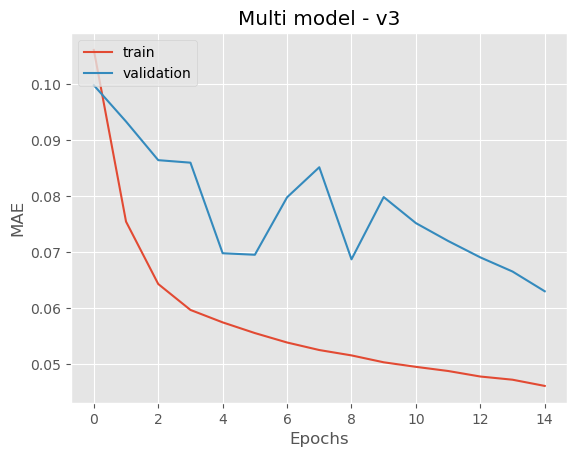

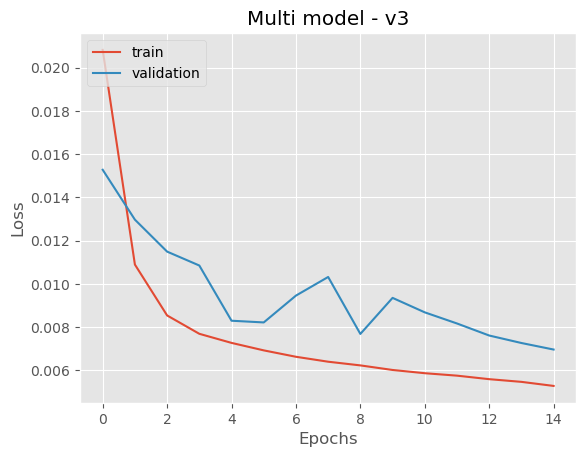

In [18]:
def training_loss(history):
    plt.style.use('ggplot')
    plt.plot(history.history['mae'])
    plt.plot(history.history['val_mae'])
    plt.title('Multi model - v3')
    plt.ylabel('MAE')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()
    plt.style.use('ggplot')
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Multi model - v3')
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(['train', 'validation'], loc='upper left')
    plt.show()

training_loss(history_multi_v3)

## Model evaluation

In [9]:
model_concat = load_model("models/norm_det_multi_v1.hdf5")

In [10]:
# MODELS EVALUATION ON TEST DATA WITHOUT NOISE
scores1 = model_concat.evaluate(X_test, y_test)
print('Multi model v1 -- Loss: {:.4f}, MAE: {:.4f}'.format(scores1[0], scores1[1]))

625/625 [==============================] - 17s 27ms/step - loss: 0.3175 - mean_absolute_error: 0.4895 - mean_absolute_percentage_error: 14970493.0000
Multi model v1 -- Loss: 0.3175, MAE: 0.4895


In [11]:
# Adding noise to normalized test data
X_test_n = []
y_test_norm_n = []
for i in range(len(X_test)):
    for j in range(3):
        curve = stochastic_noise_generator(X_test[i])
        X_test_n.append(curve[0])
        y_test_norm_n.append(y_test[i])
        j += 1
X_test_n = np.array(X_test_n)
y_test_norm_n = np.array(y_test_norm_n)

In [14]:
# Normalized test data with noise
scores_n = model_concat.evaluate(X_test_n, y_test_norm_n)
print('Loss: {:.4f}, MAE: {:.4f}'.format(scores_n[0], scores_n[1]))

1875/1875 [==============================] - 58s 31ms/step - loss: 0.3142 - mean_absolute_error: 0.4884 - mean_absolute_percentage_error: 15008573.0000 3s - loss: 0.3143 - mean_absolute
Loss: 0.3142, MAE: 0.4884


## Prediction on test data without noise

In [16]:
y_pred_norm = model_concat.predict(X_test)
denorm = scaler.inverse_transform(y_pred_norm)
denorm[0]

array([  1.3632575,   7.5382347,  82.35166  , 741.6608   ,   8.739022 ],
      dtype=float32)

In [17]:
denorm_pred_df = pd.DataFrame(denorm,
                           columns = [
                                "inclination",
                                "mass_ratio",
                                "primary__surface_potential",
                                "secondary__surface_potential",
                                "t1_t2"
                            ])
pred_mean = denorm_pred_df.mean(axis=0)

In [18]:
y_test_df = pd.DataFrame(y,
                        columns = [
                            "inclination",
                            "mass_ratio",
                            "primary__surface_potential",
                            "secondary__surface_potential",
                            "t1_t2"
                            ])
test_mean = y_test_df.mean(axis=0)

In [19]:
eval_pred = pd.DataFrame({'attribute': test_mean.index,
            'avg_true': test_mean.values,
            'avg_pred': pred_mean.values,
            'MAE': abs(test_mean.values - pred_mean.values)})
eval_pred

,attribute,avg_true,avg_pred,MAE
0,inclination,1.375792,1.317150,0.058642
1,mass_ratio,1.749395,6.986374,5.236980
2,primary__surface_potential,18.224785,76.769684,58.544898
3,secondary__surface_potential,16.789932,688.823303,672.033371
4,t1_t2,2.660959,8.156228,5.495269


## Prediction on normalized test data with noise

In [20]:
y_pred_norm_n = model_concat.predict(X_test_n)
denorm_n = scaler.inverse_transform(y_pred_norm_n)
denorm_n[0]

array([  1.3466185,   7.300246 ,  80.61077  , 725.35535  ,   8.488098 ],
      dtype=float32)

In [21]:
denorm_pred_n_df = pd.DataFrame(denorm_n,
                            columns = [
                                "inclination",
                                "mass_ratio",
                                "primary__surface_potential",
                                "secondary__surface_potential",
                                "t1_t2"
                            ])
pred_n_mean = denorm_pred_n_df.mean(axis=0)

In [23]:
y_test_n_denorm = scaler.inverse_transform(y_test_norm_n)
y_test_norm_n_df = pd.DataFrame(y_test_n_denorm,
                            columns = [
                            "inclination",
                            "mass_ratio",
                            "primary__surface_potential",
                            "secondary__surface_potential",
                            "t1_t2"
                            ])
test_mean_n = y_test_norm_n_df.mean(axis=0)


In [24]:
eval_pred = pd.DataFrame({'attribute': test_mean_n.index,
            'avg_true': test_mean_n.values,
            'avg_pred': pred_n_mean.values,
            'MAE': abs(test_mean_n.values - pred_n_mean.values)})
eval_pred

,attribute,avg_true,avg_pred,MAE
0,inclination,1.375910,1.314814,0.061096
1,mass_ratio,1.747564,6.956733,5.209168
2,primary__surface_potential,18.126015,76.454735,58.328720
3,secondary__surface_potential,16.289401,686.029785,669.740385
4,t1_t2,2.675162,8.126790,5.451628
